### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import sklearn

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import style
style.use('ggplot')

from sklearn.model_selection import KFold, GridSearchCV, cross_validate, ParameterGrid, train_test_split, cross_val_score
from sklearn.base import clone
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier, RadiusNeighborsClassifier
from sklearn.svm import SVC, LinearSVC, NuSVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier

from sklearn import (
    ensemble, 
    gaussian_process,
    linear_model,
    naive_bayes,
    tree, 
    discriminant_analysis
)

from sklearn.ensemble import StackingClassifier, VotingClassifier

### Import the Train data set and Test data set 

In [2]:
loc_train = 'data\\train.csv'
loc_test = 'data\\test.csv'
target = 'Survived'

raw_train_data = pd.read_csv(loc_train)
y = raw_train_data[target]
raw_test_data = pd.read_csv(loc_test)
raw_train_data.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# from sklearn.datasets import load_iris
# R, t = load_iris(True, True)
# raw_train_data, raw_test_data, y, v = train_test_split(R, t, random_state=47)
# raw_train_data.head(5)

In [4]:
raw_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


### Prepare the data for Machine Learning

In [5]:
scaler = StandardScaler().fit(raw_train_data[['Age', 'Fare']])
def prepare(original_DF, com = True):
    DF = original_DF.copy()
    
    age_map = [int(DF[DF.Pclass==c].Age.mean()) for c in range(1, 4)]
    for c in range(1, 4):
        DF.loc[
            DF.Age.isnull() & (DF.Pclass==c), 'Age'
        ] = age_map[c-1]
    
    
    
    DF['Embarked'].fillna(DF.Embarked.mode()[0], inplace = True)
    
    
    Fare_map = [int(DF[DF.Pclass==c].Fare.mean()) for c in range(1, 4)]
    for c in range(1, 4):
        DF.loc[
            DF.Fare.isnull() & (DF.Pclass==c), 'Fare'
        ] = Fare_map[c-1]
        
    DF[['Age', 'Fare']] = scaler.transform(DF[['Age', 'Fare']])
    
        
    DF['FamilySize'] = DF.SibSp + DF.Parch
    
    
    sex_mapping = {'male': 1, 'female': 0}
    DF['Sex'] = DF.Sex.map(sex_mapping)
    
    
    
    DF['Title'] = DF['Name'].str.split(', ', expand=True)[1].str.split('.', expand=True)[0]
    titlefrq = DF.Title.value_counts() < 10
    DF['Title'] = DF['Title'].apply(lambda s: 'Misc' if titlefrq.loc[s] == True else s)
    
    
    DF['Cabin'] = DF.Cabin.notnull().astype(int)
    
    DF = DF[['Pclass', 'Sex', 'Age', 'Fare', 'Cabin', 'Embarked', 'FamilySize', 'Title']]
    
    if not com:
        return DF
    
    DF = pd.get_dummies(DF)
    
    return DF  

In [6]:
train_X = prepare(raw_train_data)
test_X = prepare(raw_test_data)

F = train_X.copy()
F['y'] = y
F.head()

,Pclass,Sex,Age,Fare,Cabin,FamilySize,Embarked_C,Embarked_Q,Embarked_S,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,y
0,3,1,-0.530377,-0.502445,0,1,0,0,1,0,0,0,1,0,0
1,1,0,0.571831,0.786845,1,1,1,0,0,0,0,0,0,1,1
2,3,0,-0.254825,-0.488854,0,0,0,0,1,0,0,1,0,0,1
3,1,0,0.365167,0.420730,1,1,0,0,1,0,0,0,0,1,1
4,3,1,0.365167,-0.486337,0,0,0,0,1,0,0,0,1,0,0


In [7]:
F.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Pclass        891 non-null    int64  
 1   Sex           891 non-null    int64  
 2   Age           891 non-null    float64
 3   Fare          891 non-null    float64
 4   Cabin         891 non-null    int32  
 5   FamilySize    891 non-null    int64  
 6   Embarked_C    891 non-null    uint8  
 7   Embarked_Q    891 non-null    uint8  
 8   Embarked_S    891 non-null    uint8  
 9   Title_Master  891 non-null    uint8  
 10  Title_Misc    891 non-null    uint8  
 11  Title_Miss    891 non-null    uint8  
 12  Title_Mr      891 non-null    uint8  
 13  Title_Mrs     891 non-null    uint8  
 14  y             891 non-null    int64  
dtypes: float64(2), int32(1), int64(4), uint8(8)
memory usage: 52.3 KB


### Visualize

In [8]:
F.corr().abs().sort_values('y', ascending=False).y

y               1.000000
Title_Mr        0.549199
Sex             0.543351
Title_Mrs       0.339040
Pclass          0.338481
Title_Miss      0.327093
Cabin           0.316912
Fare            0.257307
Embarked_C      0.168240
Embarked_S      0.149683
Title_Master    0.085221
Age             0.050118
Title_Misc      0.022030
FamilySize      0.016639
Embarked_Q      0.003650
Name: y, dtype: float64

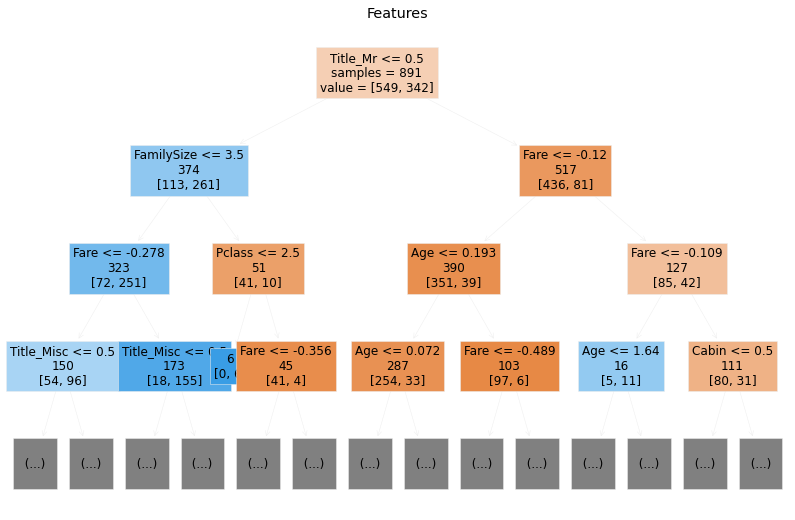

In [9]:
dt = DecisionTreeClassifier().fit(train_X, y)
plt.figure(figsize = (14, 9))
plot_tree(dt, 
          max_depth = 3, 
          filled = True, 
          fontsize=12, 
          label='root', 
          impurity=False, 
          feature_names=train_X.columns
         )
plt.title('Features')
plt.show()

### List of Classifiers
https://scikit-learn.org/stable/supervised_learning.html

In [10]:
# https://scikit-learn.org/stable/supervised_learning.html

Classifiers_small = [
    MLPClassifier(), 
    KNeighborsClassifier(), 
    SVC(class_weight='balanced'), 
    SGDClassifier(class_weight='balanced'), 
    RandomForestClassifier(class_weight='balanced')
]

Classifiers_medium = [
    LinearSVC(class_weight='balanced'),
    GaussianProcessClassifier(), 
    DecisionTreeClassifier(class_weight='balanced'), 
    AdaBoostClassifier(), 
    GaussianNB(), 
    QuadraticDiscriminantAnalysis(), 
    GradientBoostingClassifier(), 
]

Classifiers_large = [    
    linear_model.LogisticRegressionCV(), 
    linear_model.PassiveAggressiveClassifier(), 
    linear_model.RidgeClassifierCV(), 
    linear_model.Perceptron(), 
    
    NuSVC(class_weight='balanced'), 
    LinearDiscriminantAnalysis(),
    
    naive_bayes.MultinomialNB(), 
    naive_bayes.ComplementNB(), 
    naive_bayes.BernoulliNB(), 
    naive_bayes.CategoricalNB(), 
    
    ensemble.ExtraTreesClassifier(class_weight='balanced'),
]

### Tips on Practical Use of some classifiers

https://scikit-learn.org/stable/modules/svm.html#tips-on-practical-use

https://scikit-learn.org/stable/modules/sgd.html#tips-on-practical-use

https://scikit-learn.org/stable/modules/tree.html#tips-on-practical-use

https://scikit-learn.org/stable/modules/neural_networks_supervised.html#tips-on-practical-use


### Parameter Grid

In [11]:
# parameter tuning
mlpc_parameters = {
    'activation': ['relu', 'logistic'], 
    'alpha': 10.0 ** -np.arange(1, 7),
}

knn_parameters = {
    'n_neighbors': range(1, 20),
    'weights': ['uniform', 'distance']
}

svc_parameters = {
    'class_weight': ['balanced', None],
    'gamma': ['scale', 'auto']    
}

sgd_parameters = {
    'alpha': 10.0**-np.arange(1,7),
    'class_weight': [None, 'balanced'],
}

rf_parameters = {
    'n_estimators': [500], 
    'class_weight': ['balanced', None]
}

### Making the list of Classifiers

In [12]:
mlpc_models = [MLPClassifier(**params) for params in ParameterGrid(mlpc_parameters)]
knn_models = [KNeighborsClassifier(**params) for params in ParameterGrid(knn_parameters)]
svc_models = [SVC(**params) for params in ParameterGrid(svc_parameters)]
sgd_models = [SGDClassifier(**params) for params in ParameterGrid(sgd_parameters)]
rf_models = [RandomForestClassifier(**params) for params in ParameterGrid(rf_parameters)]

In [13]:
MLA = Classifiers_small
MLA = mlpc_models + svc_models + sgd_models + rf_models + knn_models
MLA = MLA + Classifiers_medium
MLA = MLA + Classifiers_large

### Checking the accuracy of each of the Classifiers
https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html

In [14]:
paramlist = ['activation', 'alpha', 'class_weight', 'n_neighbours', 'weights', 'gamma', 'n_estimators',
            'final_estimator']
metrics = ['fit_time', 'test_score']
def cv(alg, X, y):
    name = alg.__class__.__name__
#     print (alg)
#     params = alg.get_params()
#     imp_params = {p: params[p] for p in params if p in paramlist}
    
    score = pd.DataFrame(cross_validate(alg, X, y, scoring='accuracy'))
#     print (score.mean())
    
    df = pd.DataFrame({
        name: [alg] + 
        #[imp_params] + 
        [score[i].mean() for i in metrics] + [score['test_score'].std()]
    })
    
    return df.transpose()

def CVscoreDF(MLA, X, y):
    M = pd.DataFrame()
    for alg in MLA:
        M = M.append(cv(alg, X, y))

    M = M.rename(columns={i: c for i, c in enumerate(['models']+metrics+['std_test_score'])})
    M = M.sort_values('test_score', ascending = False)
    return M

In [15]:
Score = CVscoreDF(MLA, train_X, y)
Score.head(10)

,models,fit_time,test_score,std_test_score
MLPClassifier,MLPClassifier(alpha=0.1),1.46239,0.837267,0.0213349
RidgeClassifierCV,"RidgeClassifierCV(alphas=array([ 0.1, 1. , 10...",0.0321278,0.836125,0.0309603
LinearDiscriminantAnalysis,LinearDiscriminantAnalysis(),0.0127831,0.836125,0.0309603
MLPClassifier,MLPClassifier(),1.41623,0.835013,0.0265521
SVC,SVC(gamma='auto'),0.0133992,0.833877,0.0257452
MLPClassifier,MLPClassifier(alpha=1e-06),1.39537,0.832773,0.030091
SVC,SVC(),0.0134104,0.832754,0.0263001
MLPClassifier,MLPClassifier(activation='logistic'),0.965167,0.831636,0.0252255
MLPClassifier,"MLPClassifier(activation='logistic', alpha=1e-05)",0.897007,0.831636,0.027899
MLPClassifier,"MLPClassifier(activation='logistic', alpha=0.001)",0.949788,0.830513,0.0296622


### Stack Ensembling
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html

https://scikit-learn.org/stable/modules/linear_model.html

In [16]:
# List of the Classifiers to be stacked

MLA = Score.models.head(40).to_list()
Stack_estimators = [
    (a.__class__.__name__ + str(i), a) for i, a in enumerate(MLA)
]
Stack_estimators[:5]

[('MLPClassifier0', MLPClassifier(alpha=0.1)),
 ('RidgeClassifierCV1', RidgeClassifierCV(alphas=array([ 0.1,  1. , 10. ]))),
 ('LinearDiscriminantAnalysis2', LinearDiscriminantAnalysis()),
 ('MLPClassifier3', MLPClassifier()),
 ('SVC4', SVC(gamma='auto'))]

In [17]:
stack_parameters = {
    'final_estimator': [
        LinearSVC(), 
        linear_model.Perceptron(), 
        linear_model.LogisticRegressionCV(), 
        None
    ] #+ sgd_models
}
# stack_models = [StackingClassifier(Stack_estimators, **params) for params in ParameterGrid(stack_parameters)]
gscv = GridSearchCV(StackingClassifier(Stack_estimators), stack_parameters)

In [18]:
gscv.fit(train_X, y)
score = pd.DataFrame(gscv.cv_results_).sort_values('rank_test_score')
score[['params', 'mean_test_score', 'rank_test_score', 'std_test_score']].head()
# score = CVscoreDF(stack_models, train_X, y)
# score

,params,mean_test_score,rank_test_score,std_test_score
0,{'final_estimator': LinearSVC()},0.843971,1,0.024337
2,{'final_estimator': LogisticRegressionCV()},0.838353,2,0.025137
3,{'final_estimator': None},0.836131,3,0.025523
1,{'final_estimator': Perceptron()},0.701839,4,0.190178


### If still unsatisfied:
https://mlens.readthedocs.io/en/0.1.x/source/mlens.ensemble/

### Choose your Classifier and Predict on the test data set

In [19]:
final_classifier = Score.models.iloc[2]
final_classifier.fit(train_X, y)
final_classifier = gscv

In [20]:
predictions = final_classifier.predict(test_X)

In [21]:
output = pd.DataFrame({'PassengerID': raw_test_data.PassengerId, 'Survived': predictions})
output.to_csv('preds\\gscv_3.csv', index = False)